In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps' if torch.backends.mps.is_available() else device)
print(f"Using device: {device}")

Using device: cpu


In [16]:
class PINN(nn.Module):
    """
    Physics-Informed Neural Network for solving PDEs.

    The network takes (x, t) as input and outputs u(x, t).
    """

    def __init__(self, layers):
        super(PINN, self).__init__()

        self.layers = nn.ModuleList()

        # Build the network
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

        # Initialize weights using Xavier initialization
        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x, t):
        # Concatenate inputs
        inputs = torch.cat([x, t], dim=1)

        # Pass through hidden layers with tanh activation
        for i in range(len(self.layers) - 1):
            inputs = torch.tanh(self.layers[i](inputs))

        # Output layer (no activation)
        output = self.layers[-1](inputs)

        return output

## 1. Burgers

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

This is a nonlinear PDE that models fluid dynamics.

In [17]:
def compute_pde_residual(model, x, t, nu=0.01):
    """
    Compute the PDE residual for the heat equation.

    PDE: du/dt - alpha * d2u/dx2 = 0
    """
    x.requires_grad = True
    t.requires_grad = True

    # Forward pass
    u = model(x, t)

    # Compute gradients
    u_x = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]

    u_t = torch.autograd.grad(
        u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]

    # Second derivative with respect to x
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True
    )[0]

    # PDE residual
    residual = u_t + u * u_x - nu * u_xx

    return residual


def initial_condition(x):
    """
    Initial condition: u(x, 0) = sin(pi * x)
    """
    return torch.sin(np.pi * x)


def boundary_condition(t):
    """
    Boundary conditions: u(0, t) = u(1, t) = 0
    """
    return torch.zeros_like(t)

In [18]:
def train_pinn(
    model,
    n_epochs=5000,
    lr=0.001,
    n_collocation=10000,
    n_initial=100,
    n_boundary=100,
    nu=0.01,
):
    """
    Train the Physics-Informed Neural Network.

    Args:
        model: PINN model
        n_epochs: Number of training epochs
        lr: Learning rate
        n_collocation: Number of collocation points for PDE
        n_initial: Number of points for initial condition
        n_boundary: Number of points for boundary conditions
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Generate collocation points for PDE (random points in domain)
        x_pde = torch.rand(n_collocation, 1, requires_grad=True).to(device)
        t_pde = torch.rand(n_collocation, 1, requires_grad=True).to(device)

        # Initial condition points (t=0)
        x_ic = torch.rand(n_initial, 1).to(device)
        t_ic = torch.zeros(n_initial, 1).to(device)
        u_ic = initial_condition(x_ic)

        # Boundary condition points (x=0 and x=1)
        t_bc = torch.rand(n_boundary, 1).to(device)
        x_bc_left = torch.zeros(n_boundary, 1).to(device)
        x_bc_right = torch.ones(n_boundary, 1).to(device)
        u_bc = boundary_condition(t_bc)

        # Compute losses

        # 1. PDE residual loss
        residual = compute_pde_residual(model, x_pde, t_pde, alpha)
        loss_pde = torch.mean(residual**2)

        # 2. Initial condition loss
        u_pred_ic = model(x_ic, t_ic)
        loss_ic = torch.mean((u_pred_ic - u_ic) ** 2)

        # 3. Boundary condition loss
        u_pred_bc_left = model(x_bc_left, t_bc)
        u_pred_bc_right = model(x_bc_right, t_bc)
        loss_bc = torch.mean((u_pred_bc_left - u_bc) ** 2) + torch.mean(
            (u_pred_bc_right - u_bc) ** 2
        )

        # Total loss
        loss = loss_pde + loss_ic + loss_bc

        # Backpropagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Print progress
        if (epoch + 1) % 500 == 0:
            print(
                f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.6f}, "
                f"PDE: {loss_pde.item():.6f}, IC: {loss_ic.item():.6f}, "
                f"BC: {loss_bc.item():.6f}"
            )

    return losses

In [19]:
import numpy as np
from scipy.special import iv


def analytical_solution(x, t, nu, n_terms=100):
    """
    Computes the analytical solution to the 1D viscous Burgers' equation
    using the Cole-Hopf transformation.

    Parameters:
    -----------
    x : array_like or float
        Spatial coordinate(s) in the domain [0, 1].
    t : float
        Time point (t > 0).
    nu : float
        Viscosity coefficient.
    n_terms : int, optional
        Number of terms to include in the Fourier series summation.
        Default is 100. Increase for higher accuracy at small t or small nu.

    Returns:
    --------
    u : ndarray or float
        The velocity u(x, t).
    """
    # Argument for the Bessel functions
    z = 1.0 / (2.0 * np.pi * nu)

    # Initialize numerator and denominator sums
    # Denominator starts with I_0(z) (the n=0 term)
    denominator = iv(0, z)
    numerator = 0.0

    # Calculate the infinite series (truncated at n_terms)
    for n in range(1, n_terms + 1):
        # Temporal decay term
        decay = np.exp(-(n**2) * np.pi**2 * nu * t)

        # Bessel function term I_n(z)
        bessel_val = iv(n, z)

        # Accumulate sums
        numerator += n * bessel_val * np.sin(n * np.pi * x) * decay
        denominator += 2 * bessel_val * np.cos(n * np.pi * x) * decay

    # Final computation of u(x,t)
    u = (4 * np.pi * nu * numerator) / denominator

    return u

## 6. Train the Model

In [20]:
# Define network architecture
layers = [2, 32, 32, 32, 1]  # Input: (x, t), Output: u

# Create model
model = PINN(layers).to(device)
print(model)

# Thermal diffusivity
alpha = 1
nu = 0.01

# Train the model
print("\nTraining PINN...")
losses = train_pinn(model, n_epochs=10000, lr=0.001, nu=nu)

PINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1-2): 2 x Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

Training PINN...
Epoch [500/10000], Loss: 0.073245, PDE: 0.009610, IC: 0.043980, BC: 0.019655
Epoch [1000/10000], Loss: 0.011490, PDE: 0.005489, IC: 0.003995, BC: 0.002006
Epoch [1500/10000], Loss: 0.002374, PDE: 0.001594, IC: 0.000334, BC: 0.000446
Epoch [2000/10000], Loss: 0.000737, PDE: 0.000560, IC: 0.000073, BC: 0.000104
Epoch [2500/10000], Loss: 0.000351, PDE: 0.000279, IC: 0.000019, BC: 0.000054
Epoch [3000/10000], Loss: 0.000217, PDE: 0.000176, IC: 0.000013, BC: 0.000028
Epoch [3500/10000], Loss: 0.000387, PDE: 0.000322, IC: 0.000015, BC: 0.000050
Epoch [4000/10000], Loss: 0.000403, PDE: 0.000331, IC: 0.000013, BC: 0.000058
Epoch [4500/10000], Loss: 0.000111, PDE: 0.000083, IC: 0.000011, BC: 0.000017
Epoch [5000/10000], Loss: 0.000098, PDE: 0.000067, IC: 0.0000

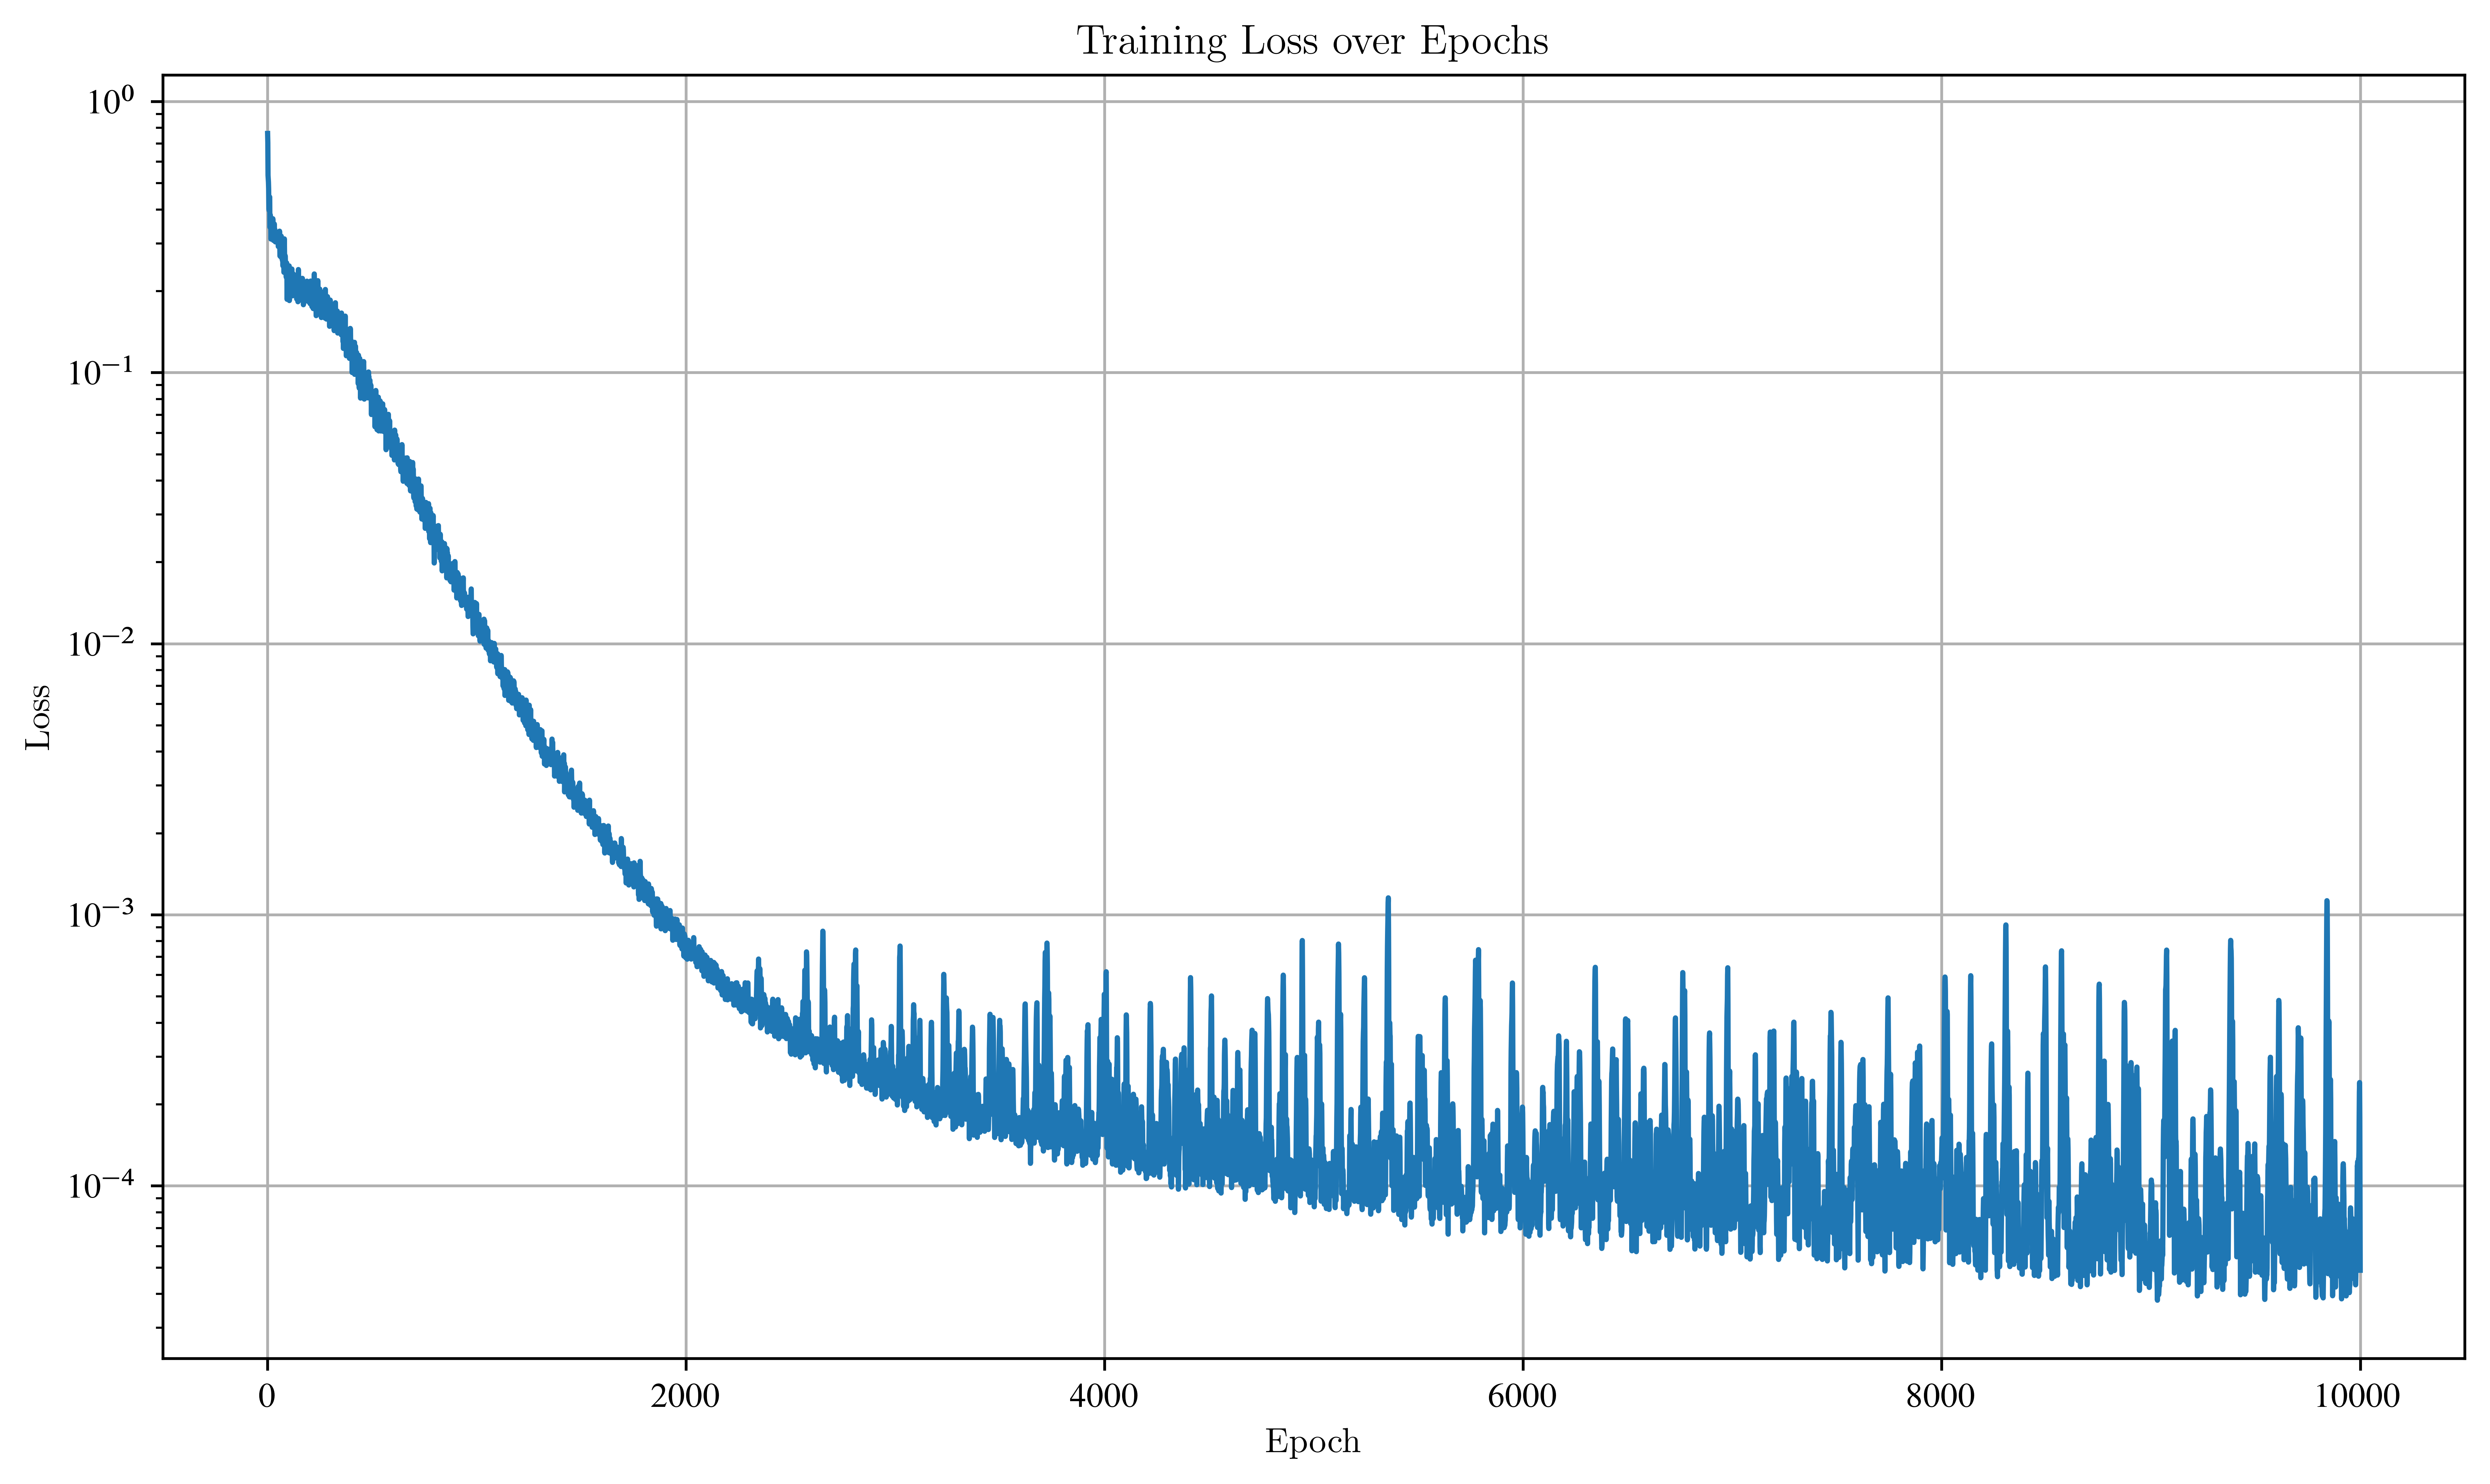

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.yscale("log")
plt.grid(True)
plt.show()

## Evaluate and Compare with Analytical Solution

In [22]:
# Create a grid for evaluation
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)

# Flatten for prediction
x_flat = X.flatten()[:, None]
t_flat = T.flatten()[:, None]

# Convert to tensors
x_tensor = torch.FloatTensor(x_flat).to(device)
t_tensor = torch.FloatTensor(t_flat).to(device)

# Predict with PINN
model.eval()
with torch.no_grad():
    u_pred = model(x_tensor, t_tensor).cpu().numpy()

U_pred = u_pred.reshape(X.shape)

# Analytical solution
U_exact = analytical_solution(X, T, alpha)

# Compute error
error = np.abs(U_pred - U_exact)
relative_error = np.linalg.norm(error) / np.linalg.norm(U_exact)
print(f"\nRelative L2 error: {relative_error:.6f}")


Relative L2 error: 0.007149


## Visualize Results

In [23]:
# 3D surface plots
fig = plt.figure(figsize=(18, 5))

# PINN prediction
ax1 = fig.add_subplot(131, projection="3d")
surf1 = ax1.plot_surface(X, T, U_pred, cmap=cm.viridis, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_zlabel("u(x,t)")
ax1.set_title("PINN Prediction")
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# Analytical solution
ax2 = fig.add_subplot(132, projection="3d")
surf2 = ax2.plot_surface(X, T, U_exact, cmap=cm.viridis, alpha=0.8)
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u(x,t)")
ax2.set_title("Analytical Solution")
fig.colorbar(surf2, ax=ax2, shrink=0.5)

# Error
ax3 = fig.add_subplot(133, projection="3d")
surf3 = ax3.plot_surface(X, T, error, cmap=cm.hot, alpha=0.8)
ax3.set_xlabel("x")
ax3.set_ylabel("t")
ax3.set_zlabel("|Error|")
ax3.set_title("Absolute Error")
fig.colorbar(surf3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

In [24]:
# Compare solutions at different time points
time_points = [0.0, 0.2, 0.5, 1.0]
x_plot = np.linspace(0, 1, 100)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, t_point in enumerate(time_points):
    # Prepare data
    t_plot = np.ones_like(x_plot) * t_point
    x_tensor = torch.FloatTensor(x_plot[:, None]).to(device)
    t_tensor = torch.FloatTensor(t_plot[:, None]).to(device)

    # PINN prediction
    with torch.no_grad():
        u_pred = model(x_tensor, t_tensor).cpu().numpy().flatten()

    # Analytical solution
    u_exact = analytical_solution(x_plot, t_point, alpha)

    # Plot
    axes[idx].plot(x_plot, u_exact, "b-", label="Analytical", linewidth=2)
    axes[idx].plot(x_plot, u_pred, "r--", label="PINN", linewidth=2)
    axes[idx].set_xlabel("x")
    axes[idx].set_ylabel("u(x,t)")
    axes[idx].set_title(f"t = {t_point}")
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()